<a href="https://colab.research.google.com/github/ravi7299/auto_image_annotate/blob/master/auto_image_annotate_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
## load pretrained model --yolo v3 traied on coco dataset
!wget --no-check-certificate \
     https://pretraineddlmodels.s3.amazonaws.com/yolo.zip \
    -O /tmp/yolo.zip

--2020-05-18 23:53:23--  https://pretraineddlmodels.s3.amazonaws.com/yolo.zip
Resolving pretraineddlmodels.s3.amazonaws.com (pretraineddlmodels.s3.amazonaws.com)... 52.216.26.148
Connecting to pretraineddlmodels.s3.amazonaws.com (pretraineddlmodels.s3.amazonaws.com)|52.216.26.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231267181 (221M) [application/zip]
Saving to: ‘/tmp/yolo.zip’

/tmp/yolo.zip       100%[===================>] 220.55M  47.6MB/s    in 5.1s    

2020-05-18 23:53:28 (43.5 MB/s) - ‘/tmp/yolo.zip’ saved [231267181/231267181]



In [0]:
import os
import zipfile

local_zip = '/tmp/yolo.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()



In [0]:
os.getcwd()

'/content'

In [0]:
import numpy as np
import time
import cv2
import os

dir= "../tmp/yolo/"   #base directory


In [0]:
labelsPath = dir + "yolo_v3/"+ "coco.names"
LABELS = open(labelsPath).read().strip().split("\n")

In [0]:
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),dtype="uint8")

In [0]:
weightsPath = dir + "yolo_v3/"+ "yolov3.weights"
configPath =  dir + "yolo_v3/"+ "yolov3.cfg"

In [0]:
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

In [0]:
data=dir + "images/"

ext=['.jpg', '.jpeg', '.png', '.bmp']
images=[i for i in os.listdir(data) if os.path.splitext(i)[1] in ext]

print(images)

['living_room.jpg', 'dining_table.jpg', 'baggage_claim.jpg', 'soccer.jpg']


In [0]:
img_name =images[3]  #change index for different image listed above

In [0]:
image_url= data + img_name

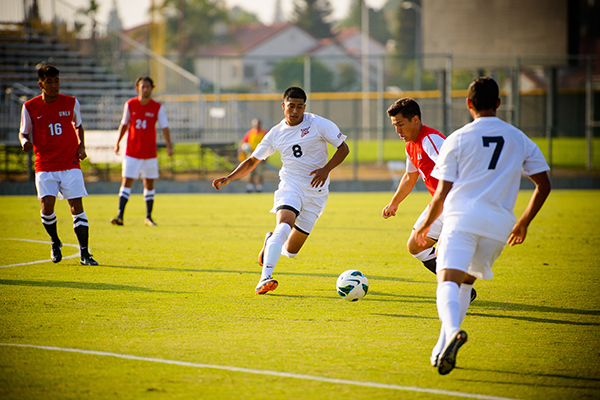

In [0]:
image = cv2.imread(image_url)
(H, W) = image.shape[:2]

#to view in colab
from google.colab.patches import cv2_imshow
cv2_imshow(image)

#to view image in jupyter notebook
#cv2.imshow("image",image)
#cv2.waitKey(0)


In [0]:
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),swapRB=True, crop=False)
net.setInput(blob)

In [0]:
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [0]:
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()

In [0]:
print(end-start)

2.2668282985687256


In [0]:
len(layerOutputs)

3

In [0]:
min_confidence=0.5
nms_threshold=0.3

In [0]:
boxes = []
confidences = []
classIDs = []

In [0]:
for output in layerOutputs:
    
    for detection in output:
        
        
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]

        if confidence > min_confidence:
            box = detection[0:4] * np.array([W, H, W, H])
            (centerX, centerY, width, height) = box.astype("int")

            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))

            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            classIDs.append(classID)

In [0]:
idxs = cv2.dnn.NMSBoxes(boxes, confidences, min_confidence,nms_threshold)

In [0]:
len(boxes)

10

In [0]:
if len(idxs) > 0:
    
    class_names=[]
    b_boxes=[]
    class_scores=[]
    image_with_boxes=image

    for i in idxs.flatten():
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        
        
        color = [int(c) for c in COLORS[classIDs[i]]]
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), color, 2)
        text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
        cv2.putText(image_with_boxes, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        b_boxes.append((x, y, x+w , y+h))
        class_scores.append(confidences[i])
        class_names.append(LABELS[classIDs[i]])
        
    
    
        
        
        

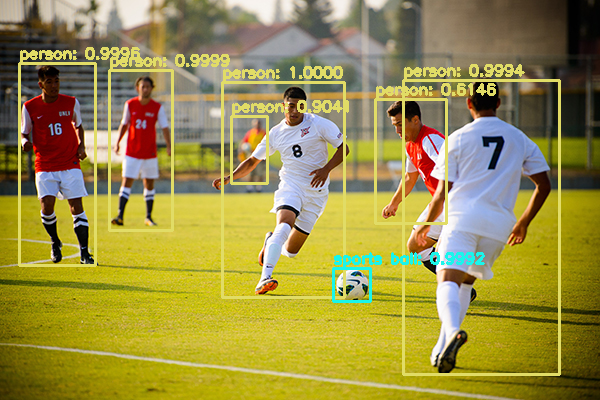

In [0]:
#for viewing image in colab
#from google.colab.patches import cv2_imshow
cv2_imshow(image_with_boxes)


#to view image in jupyter notebook
#cv2.imshow("image_with_boxes",image_with_boxes)
#cv2.waitKey(0)

In [0]:
import xml.etree.cElementTree as ET

def generate_xml(image ,file_name_ext , class_names , boxes , class_scores ):
    im_width , im_height= image.shape[1]  , image.shape[0]
    annotation = ET.Element("annotation")
    ET.SubElement(annotation, "filename").text = file_name_ext
    size = ET.SubElement(annotation, "size")
    ET.SubElement(size, "width").text = str(im_width)
    ET.SubElement(size, "height").text = str(im_height)
    ET.SubElement(size, "depth").text = "3"
    
    n=0
    
    for j,i in enumerate(boxes):
            n+=1
            xmin, ymin, xmax, ymax = tuple(boxes[j])
            objectBox = ET.SubElement(annotation, "object")
            ET.SubElement(objectBox, "name").text = class_names[j]
            ET.SubElement(objectBox, "score").text = str(class_scores[j]*100)
            ET.SubElement(objectBox, "pose").text = "Unspecified"
            ET.SubElement(objectBox, "truncated").text = "0"
            ET.SubElement(objectBox, "difficult").text = "0"
            bndBox = ET.SubElement(objectBox, "bndbox")
            ET.SubElement(bndBox, "xmin").text = str(xmin)
            ET.SubElement(bndBox, "ymin").text = str(ymin)
            ET.SubElement(bndBox, "xmax").text = str(xmax)
            ET.SubElement(bndBox, "ymax").text = str(ymax)
    
    file_name,ext = file_name_ext.split('.') 
    print(file_name)
    ref = ET.ElementTree(annotation)
    file=data +file_name+ ".xml"
    ref.write(file)
    return file, n

In [0]:
xml_file, n= generate_xml(image ,img_name , class_names ,b_boxes , class_scores )

soccer


In [0]:
#to download image with annotations

from google.colab import files

files.download(image_url) #download imags
files.download(xml_file)  #download xml annotations